In [1]:
import timm
import time 
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from medmnist import INFO
import numpy as np
import faiss
import copy
from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore")

In [2]:
torch.__version__

'2.7.1+cu126'

## Dataset 

In [3]:
## GLOBAL 

CHANNELS = 3 
N_CLASSES = 1000

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print("Using device:", device)

Using device: cuda:0


In [4]:
import os
from torchvision import datasets, transforms
import torch

print(f"Step 1: Loading dataset with resize transform...")

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225]) 
])

val_data_dir = 'dataset/imagenet_validation' 
test_data_dir = 'dataset/imagenet_tests'

val_dataset = datasets.ImageFolder(os.path.join(val_data_dir), transform=transform) 

test_datasets = {
    f'test{i}': datasets.ImageFolder(os.path.join(test_data_dir, f'test{i}'), transform=transform)
    for i in range(1, 11)
}

print(f"Validation samples: {len(val_dataset)}")
print(f"Validation samples: {len(test_datasets['test1'])}")

Step 1: Loading dataset with resize transform...
Validation samples: 30000
Validation samples: 2000


In [5]:
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4) 
test_loader = DataLoader(test_datasets['test1'], batch_size=1, shuffle=False, num_workers=4)  

In [6]:
import json
import urllib.request

url = "https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt"
imagenet_classes = urllib.request.urlopen(url).read().decode().splitlines()
print(imagenet_classes[0])

tench


## Base Models 

In [7]:
def evaluate_pool(pool, test_loader):
    print("\nEvaluating individual classifiers on test set...")

    for i, model in enumerate(pool):
        model = model.to(device)  # <- Ensure model is on the correct device
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for imgs, labels in test_loader:
                imgs, labels = imgs.to(device), labels.squeeze().long().to(device)
                outputs = model(imgs)
                preds = outputs.argmax(dim=1)
                correct += (preds == labels).sum().item()
                total += labels.numel()
        acc = correct / total * 100
        print(f"Classifier {i+1} ({model.__class__.__name__}): Accuracy = {acc:.2f}%")


In [8]:
from torchvision.models import (
    resnet18, resnet34,  
    resnet50, resnet101, resnet152, vgg11, vgg19,
    densenet201, inception_v3, googlenet, efficientnet_b0, efficientnet_b7,
    squeezenet1_1, shufflenet_v2_x1_0, mobilenet_v2, convnext_tiny
)
from torchvision.models.vision_transformer import vit_b_16, vit_l_16 
import timm  

In [9]:
trained_pool = [
        # vit_l_16(pretrained=True).eval(),  
        # efficientnet_b7(pretrained=True).eval(),  
        vit_b_16(pretrained=True).eval(), 
        vgg19(pretrained=True).eval(),
        inception_v3(pretrained=True).eval(),
        googlenet(pretrained=True, aux_logits=True, transform_input=False).eval(), 
        mobilenet_v2(pretrained=True).eval(), 
        efficientnet_b0(pretrained=True).eval(), 
        # resnet18(pretrained=True).eval(),
        # resnet34(pretrained=True).eval(),
        # resnet50(pretrained=True).eval(),
        resnet101(pretrained=True).eval()
         
       ]

In [10]:
evaluate_pool(trained_pool, test_loader)


Evaluating individual classifiers on test set...
Classifier 1 (VisionTransformer): Accuracy = 79.30%
Classifier 2 (VGG): Accuracy = 69.30%
Classifier 3 (Inception3): Accuracy = 66.40%
Classifier 4 (GoogLeNet): Accuracy = 56.55%
Classifier 5 (MobileNetV2): Accuracy = 67.75%
Classifier 6 (EfficientNet): Accuracy = 75.50%
Classifier 7 (ResNet): Accuracy = 75.50%


## VisionDES 

In [11]:
def visualize_test_and_roc(test_img, roc_imgs, local_labels, class_names=None):
    def denormalize(img_tensor, mean, std):
        mean = torch.tensor(mean).view(-1, 1, 1).to(img_tensor.device)
        std = torch.tensor(std).view(-1, 1, 1).to(img_tensor.device)
        return img_tensor * std + mean

    mean = [0.485, 0.456, 0.406]
    std  = [0.229, 0.224, 0.225] 

    k = roc_imgs.size(0)
    ncols = min(k, 5)
    nrows = 1 + (k + ncols - 1) // ncols  # one row for test image + RoC images
    
    plt.figure(figsize=(3 * ncols, 3 * nrows))
    
    # Plot test image
    plt.subplot(nrows, ncols, 1)
    denorm_img = denormalize(test_img, mean, std).clamp(0, 1)
    img_np = TF.to_pil_image(denorm_img.cpu())
    plt.imshow(img_np)
    plt.title("Test Image")
    plt.axis("off")
    
    # Plot RoC images
    for i in range(k):
        plt.subplot(nrows, ncols, i + 2)
        denorm_img = denormalize(roc_imgs[i], mean, std).clamp(0, 1)
        img_np = TF.to_pil_image(denorm_img.cpu())
        label = local_labels[i]
        if class_names:
            label = class_names[label]
        plt.imshow(img_np)
        plt.title(f"RoC #{i+1}\nLabel: {label}")
        plt.axis("off")
    
    plt.tight_layout()
    plt.show()

In [12]:
from torch.nn.functional import softmax, cosine_similarity
from collections import Counter
import matplotlib.pyplot as plt
import torchvision.transforms.functional as TF
import torch
import torch.nn as nn
import numpy as np
import faiss
from torch.utils.data import DataLoader
from tqdm import tqdm
import clip

def get_last_linear_layer(model):
    """
    Try to find the last Linear layer in the model,
    using common attribute names and fallback to scanning modules.
    """
    name = model.__class__.__name__.lower()

    # Common last layer attribute names to try (ViT, EfficientNet, etc)
    candidate_attrs = ['head', 'heads', 'classifier', 'fc', 'mlp_head']

    for attr in candidate_attrs:
        if hasattr(model, attr):
            layer = getattr(model, attr)
            # If it's directly a Linear layer
            if isinstance(layer, nn.Linear):
                return layer
            # If Sequential or Module, find last Linear inside it
            if isinstance(layer, nn.Sequential) or isinstance(layer, nn.Module):
                # Find last Linear inside this attribute recursively
                last_linear = None
                for child in reversed(list(layer.modules())):
                    if isinstance(child, nn.Linear):
                        last_linear = child
                        break
                if last_linear is not None:
                    return last_linear

    # Fallback: scan all modules and pick the last Linear
    last_linear = None
    for m in model.modules():
        if isinstance(m, nn.Linear):
            last_linear = m
    if last_linear is not None:
        return last_linear

    raise RuntimeError("No Linear layer found in model")


def get_features_before_last_linear(model, x):
    features = {}

    def find_last_linear(module):
        last_linear = None
        for m in module.modules():
            if isinstance(m, torch.nn.Linear):
                last_linear = m
        return last_linear

    last_linear = find_last_linear(model)
    if last_linear is None:
        raise RuntimeError("No Linear layer found in model")

    def hook(module, input, output):
        features['feat'] = input[0].detach()

    handle = last_linear.register_forward_hook(hook)

    model.eval()
    with torch.no_grad():
        _ = model(x)

    handle.remove()

    if 'feat' not in features:
        raise RuntimeError("Failed to capture features from last linear layer")

    return features['feat']

In [58]:
from torch.nn.functional import softmax, cosine_similarity
from collections import Counter
import matplotlib.pyplot as plt
import torchvision.transforms.functional as TF


class VisionDES: 
    def __init__(self, dsel_dataset, pool): 
        self.dsel_dataset = dsel_dataset
        self.dsel_loader = DataLoader(dsel_dataset, batch_size=32, shuffle=False) 
        self.dino_model = timm.create_model('vit_base_patch16_224.dino', pretrained=True).to(device)
        self.dino_model.eval()  
        self.pool = pool 

        self.suspected_model_votes = [] 
        
        
    def dino_embedder(self, images):
        if images.shape[1] == 1:
            images = images.repeat(1, 3, 1, 1)
        return self.dino_model.forward_features(images)


    def fit(self): 
        dsel_embeddings = []
        dsel_labels = []
    
        with torch.no_grad():
            for imgs, labels in tqdm(self.dsel_loader):
                imgs = imgs.to(device)
                embs = self.dino_embedder(imgs).cpu()  
                dsel_embeddings.append(embs)
                dsel_labels.append(labels)
    
        # Keep as tensor
        dsel_embeddings_tensor = torch.cat(dsel_embeddings).detach().cpu()  
        cls_tensor = dsel_embeddings_tensor[:, 0, :]  
    
        # Convert to NumPy
        cls_embeddings = np.ascontiguousarray(cls_tensor.numpy(), dtype='float32')
        self.dsel_embeddings = cls_embeddings
        self.dsel_labels = torch.cat(dsel_labels).numpy()
    
        # Build FAISS index
        embedding_dim = cls_embeddings.shape[1]
        self.index = faiss.IndexFlatL2(embedding_dim)
        self.index.add(cls_embeddings)

    
    def get_output_size(self, model):
        """
        Returns the output size (number of classes) from various model architectures.
        """
        if hasattr(model, 'fc'):
            return model.fc.out_features
        elif hasattr(model, 'classifier'):
            if isinstance(model.classifier, nn.Sequential):
                return model.classifier[-1].out_features
            else:
                return model.classifier.out_features
        elif hasattr(model, 'heads'):  # ViT / DINO from torchvision
            return model.heads.head.out_features
        elif hasattr(model, 'head'):  # ViT/Swin from timm
            return model.head.out_features
        else:
            raise AttributeError("Cannot determine output size of the model.")


    def predict_weighted_robust(self, test_img, k=7, return_logits=False, explain=False):
        # Step 1: Get DINO CLS embedding for the test image
        img_for_dino = test_img.unsqueeze(0).to(device)

        with torch.no_grad():
            test_emb = self.dino_model.forward_features(img_for_dino).cpu().numpy().astype('float32')
            test_emb = test_emb[:, 0, :]  # CLS token only
    
        # Step 2: Find k nearest neighbors in FAISS (Region of Competence)
        distances, neighbors = self.index.search(test_emb, k)
        neighbor_idxs = neighbors[0]
        local_labels = self.dsel_labels[neighbor_idxs]
        local_labels = np.array(local_labels).flatten()
    
        # Step 3: Get RoC images
        with torch.no_grad():
            roc_imgs = torch.stack([self.dsel_dataset[idx][0] for idx in neighbor_idxs]).to(device)
    
        # Step 4: Evaluate classifiers — compute competence and feature similarity
        competences = []
        feature_similarities = []
        soft_outputs = []
    
        test_img_batch = test_img.unsqueeze(0).to(device)
    
        for clf in self.pool:
            clf.eval()
            with torch.no_grad():
                outputs = clf(roc_imgs)
                preds = outputs.argmax(dim=1).cpu().numpy()
                correct = (preds == local_labels).sum()
                competence = correct / k
                competences.append(competence)

                logits = clf(test_img.unsqueeze(0).to(device)).squeeze(0)
                probs = softmax(logits, dim=0)
                soft_outputs.append(probs)

                # Feature similarity using ResNet embeddings
                test_feat = get_features_before_last_linear(clf, test_img.unsqueeze(0).to(device))
                roc_feats = get_features_before_last_linear(clf, roc_imgs)
                mean_feat = roc_feats.mean(dim=0, keepdim=True)

                sim = cosine_similarity(test_feat / test_feat.norm(), mean_feat / mean_feat.norm(), dim=1)
                feature_similarities.append(sim.item())
    
        # Step 5: Combine competence & feature similarity into a score
        alpha = 1.0  # adjust influence of similarity
        combined_scores = [c * (s / alpha) for c, s in zip(competences, feature_similarities)]
    
        # Step 6: Normalize to get weights
        total_score = sum(combined_scores)
        if total_score == 0:
            weights = [1.0 / len(self.pool)] * len(self.pool)
        else:
            weights = [s / total_score for s in combined_scores]
    
        # Step 7: Weighted aggregation of classifier outputs
        num_classes = self.get_output_size(self.pool[0])
        weighted_logits = torch.zeros(num_classes).to(device)
        for prob, weight in zip(soft_outputs, weights):
            weighted_logits += weight * prob
    
        # Step 8: Keep track of suspected attacked model
        min_sim_idx = int(np.argmin(feature_similarities))
        self.suspected_model_votes.append(min_sim_idx)

        # Step 8: Optional explainability
        if explain:
            print("\nExplainability Report:")
            for idx, (clf, comp, sim, weight, prob) in enumerate(zip(self.pool, competences, feature_similarities, weights, soft_outputs)):
                pred_class = prob.argmax().item()
                conf = prob[pred_class].item()
                topk = torch.topk(prob, k=2)
                print(f"Model #{idx}: {clf.__class__.__name__}")
                print(f"  - Competence: {comp:.4f}")
                print(f"  - Feature similarity: {sim:.4f}")
                print(f"  - Combined weight: {weight:.4f}")
                print(f"  - Predicted class: {pred_class} with confidence {conf:.4f}")
                print(f"  - Top-5: {topk.indices.tolist()} → {[round(p.item(), 3) for p in topk.values]}")
                print("-" * 50)
    
            print(f"\n🧠 Final prediction: {weighted_logits.argmax().item()}")
            top5 = torch.topk(weighted_logits, k=2)
            print(f"🔝 Top-5 predictions:")
            for i in range(2):
                print(f"  - Class {top5.indices[i].item()}: {top5.values[i].item():.4f}")
    
            print("\nModel weight distribution:")
            for idx, w in enumerate(weights):
                print(f"  Model #{idx}: {w:.4f}")
            print(f"Suspected attacked model: Model #{min_sim_idx} ({self.pool[min_sim_idx].__class__.__name__})")
    
            print("\nRoC visualization:")
            visualize_test_and_roc(test_img.squeeze(0), roc_imgs, local_labels)
            print(distances)

        if return_logits:
            return weighted_logits
        return weighted_logits.argmax().item()


In [59]:
des_model = VisionDES(val_dataset, trained_pool)
des_model.fit()

100%|█████████████████████████████████████████████████████████████████| 938/938 [04:00<00:00,  3.90it/s]


In [60]:
def evaluate_des_with_fails(des_model, dataloader, dataset, use_v3=True, k=7):
    """
    Evaluate DES model, print accuracy, and return indices of failed predictions.
    
    Args:
        des_model: The VisionDES model
        dataloader: DataLoader for test data
        dataset: Original dataset (to map dataloader indices back)
        use_v3: If True, use predict_weighted_robust_feature_similarity_v3
        k: Number of neighbors in RoC
    """
    total = 0
    correct = 0
    failed_indices = []
    dataset_offset = 0  # to map dataloader batches back to dataset indices

    with torch.no_grad():
        for imgs, labels in tqdm(dataloader, desc="Testing VisionDES"):
            imgs, labels = imgs.to(device), labels.to(device)

            preds = []
            for idx_in_batch, img in enumerate(imgs):
                if use_v3:
                    pred = des_model.predict_weighted_robust(
                        img, k=k, return_logits=False, explain=False
                    )
                else:
                    pred = des_model.predict_weighted_robust_feature_similarity(
                        img, k=k, return_logits=False, explain=False
                    )
                preds.append(pred)

                # Collect failures (map batch index to dataset index)
                if pred != labels[idx_in_batch].item():
                    failed_indices.append(dataset_offset + idx_in_batch)

            preds = torch.tensor(preds).to(device)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            dataset_offset += labels.size(0)

    acc = correct / total
    print(f"✅ Test Accuracy: {acc:.4f}")
    return acc, failed_indices


In [40]:
test_loader = DataLoader(test_datasets['test2'], batch_size=1, shuffle=False, num_workers=4)  

In [32]:
test_acc, failed_indices = evaluate_des_with_fails(des_model, test_loader, test_datasets['test1'])

Testing VisionDES: 100%|████████████████████████████████████████████| 2000/2000 [09:11<00:00,  3.63it/s]

✅ Test Accuracy: 0.7825


In [41]:
test_acc, failed_indices = evaluate_des_with_fails(des_model, test_loader, test_datasets['test2'])

Testing VisionDES: 100%|████████████████████████████████████████████| 2000/2000 [09:08<00:00,  3.65it/s]

✅ Test Accuracy: 0.7850


In [44]:
print(failed_indices) 

[11, 53, 54, 63, 65, 70, 72, 80, 84, 85, 88, 89, 94, 102, 108, 109, 111, 112, 117, 119, 120, 125, 126, 131, 147, 148, 163, 173, 179, 203, 207, 217, 225, 228, 237, 248, 249, 287, 307, 326, 330, 334, 335, 341, 346, 347, 358, 360, 361, 362, 364, 370, 374, 377, 378, 381, 382, 388, 392, 403, 411, 415, 426, 428, 433, 439, 440, 444, 445, 453, 454, 463, 466, 473, 477, 478, 480, 481, 482, 484, 492, 496, 520, 523, 531, 533, 540, 548, 561, 565, 570, 578, 580, 582, 591, 594, 595, 597, 601, 606, 610, 616, 617, 621, 622, 624, 625, 629, 641, 645, 654, 658, 659, 660, 663, 674, 676, 683, 685, 691, 692, 697, 712, 713, 716, 717, 719, 732, 733, 735, 737, 754, 765, 771, 781, 782, 784, 791, 803, 805, 812, 815, 824, 825, 830, 831, 839, 845, 849, 857, 859, 863, 868, 871, 872, 873, 876, 877, 880, 883, 886, 888, 890, 892, 899, 906, 908, 910, 912, 916, 919, 926, 927, 929, 930, 932, 940, 948, 950, 954, 959, 964, 965, 974, 977, 987, 988, 989, 998, 1002, 1004, 1006, 1008, 1009, 1010, 1014, 1016, 1020, 1031, 1038, 1

True class: 5

Explainability Report:
Model #0: VisionTransformer
  - Competence: 0.8571
  - Feature similarity: 0.8573
  - Combined weight: 0.1682
  - Predicted class: 5 with confidence 0.5274
  - Top-5: [5, 6] → [0.527, 0.347]
--------------------------------------------------
Model #1: VGG
  - Competence: 0.8571
  - Feature similarity: 0.7501
  - Combined weight: 0.1472
  - Predicted class: 6 with confidence 0.7927
  - Top-5: [6, 5] → [0.793, 0.186]
--------------------------------------------------
Model #2: Inception3
  - Competence: 0.7143
  - Feature similarity: 0.8480
  - Combined weight: 0.1387
  - Predicted class: 6 with confidence 0.7910
  - Top-5: [6, 5] → [0.791, 0.209]
--------------------------------------------------
Model #3: GoogLeNet
  - Competence: 0.5714
  - Feature similarity: 0.8408
  - Combined weight: 0.1100
  - Predicted class: 6 with confidence 0.6884
  - Top-5: [6, 5] → [0.688, 0.225]
--------------------------------------------------
Model #4: MobileNetV2
 

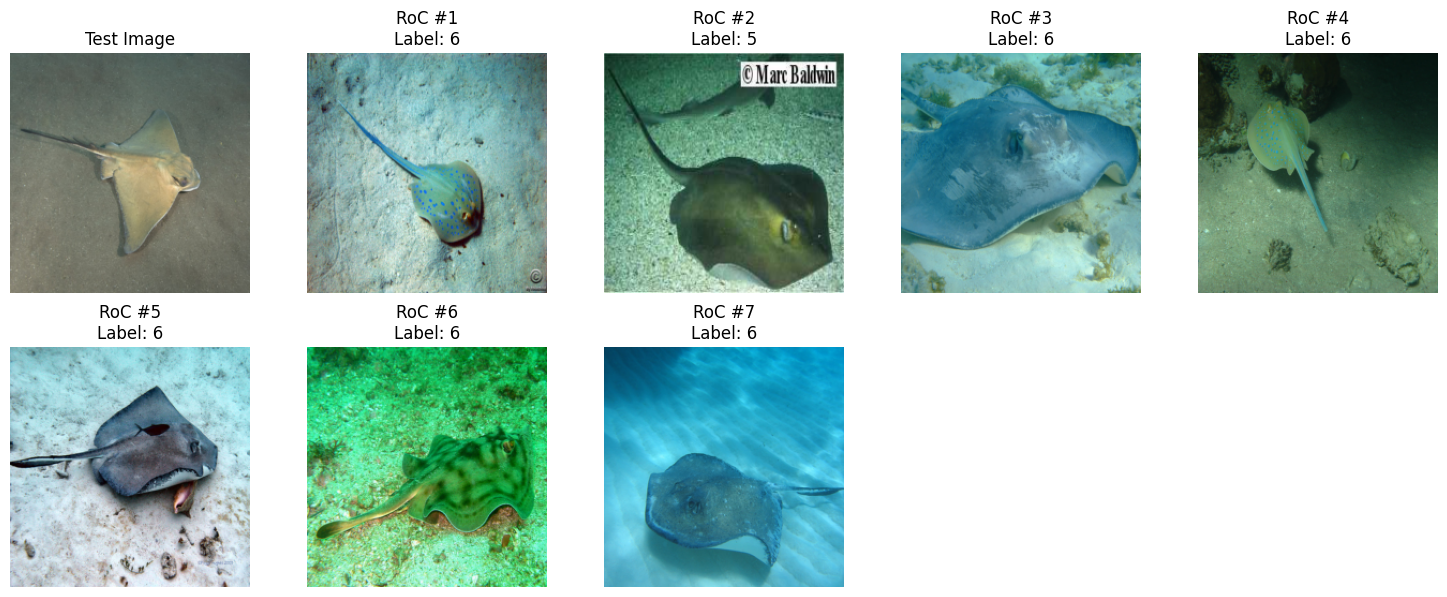

[[2756.7192 2845.8354 2980.8599 3091.4348 3127.55   3190.0083 3382.395 ]]


6

In [61]:
index = 11

print(f"True class: {test_datasets['test2'][index][1]}") 

des_model.predict_weighted_robust(test_datasets['test2'][index][0], explain=True)

## Soft Woting 

In [34]:
class SoftVotingEnsemble:
    def __init__(self, models, device='cpu'):
        self.models = models
        self.device = device
        for model in self.models:
            model.eval().to(device)

    def predict(self, images, return_probs=False):
        probs = []
        with torch.no_grad():
            for model in self.models:
                outputs = model(images.to(self.device))
                softmaxed = torch.softmax(outputs, dim=1)
                probs.append(softmaxed.cpu().numpy())
        mean_probs = np.mean(np.stack(probs), axis=0)
        if return_probs:
            return mean_probs
        return np.argmax(mean_probs, axis=1)

    def predict_single_with_probs(self, image):
        image = image.unsqueeze(0)  # Shape [1, C, H, W]
        with torch.no_grad():
            model_probs = []
            for model in self.models:
                logits = model(image.to(self.device))
                softmaxed = torch.softmax(logits, dim=1)
                model_probs.append(softmaxed.cpu().numpy())
            mean_probs = np.mean(np.stack(model_probs), axis=0)
            probs = mean_probs[0]
            pred = np.argmax(probs)
            return probs, pred

In [35]:
def evaluate_soft(des_model, dataloader):
    total = 0
    correct = 0
    
    with torch.no_grad():
        for imgs, labels in tqdm(dataloader, desc="Testing SoftVoting"):
            imgs, labels = imgs.to(device), labels.to(device)
            
            # DES prediction (you can switch to robust or explainable prediction)
            preds = []
            for img in imgs:
                _, pred = des_model.predict_single_with_probs(
                    img
                )
                preds.append(pred)
            
            preds = torch.tensor(preds).to(device)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    
    acc = correct / total
    print(f"✅ Test Accuracy: {acc:.4f}")
    return acc

In [38]:
# =========================
# Run Test
# =========================
soft_model = SoftVotingEnsemble(trained_pool, device) 

test_acc = evaluate_soft(soft_model, test_loader)

Testing SoftVoting: 100%|███████████████████████████████████████████| 2000/2000 [01:28<00:00, 22.71it/s]

✅ Test Accuracy: 0.7820


In [42]:
# =========================
# Run Test
# =========================
soft_model = SoftVotingEnsemble(trained_pool, device) 

test_acc = evaluate_soft(soft_model, test_loader)

Testing SoftVoting: 100%|███████████████████████████████████████████| 2000/2000 [01:28<00:00, 22.67it/s]

✅ Test Accuracy: 0.7850


### MultiEmbedding 

In [62]:
"""
VisionDES with Multi-Embedding RoC (DINO + CLIP)

This file provides a self-contained implementation sketch showing how to:
  - compute two different embeddings (DINO and CLIP) for a DSEL (validation) set
  - build two FAISS indexes (normalized for cosine similarity)
  - retrieve a Region of Competence (RoC) by intersecting top-k neighbors
  - fallback strategies (union or fused distances) if intersection is too small
  - an updated DES prediction method that uses the multi-embedding RoC
  - difficulty-aware weighting and explainable reporting

Notes:
  - You must supply your own `pool` (list of PyTorch classifiers), `dsel_dataset`,
    and `val_dataset` (datasets that return (image, label)).
  - This script assumes `get_features_before_last_linear` exists and returns a
    tensor of shape (batch_size, feat_dim) for a model.
  - Requires: torch, faiss, timm, clip (optional), numpy, scipy

"""

import torch
import torch.nn.functional as F
import numpy as np
import faiss
from tqdm import tqdm
from torch.nn.functional import softmax

# ------------------------------- Utilities ---------------------------------

def l2_normalize(v):
    v = v.astype('float32')
    norms = np.linalg.norm(v, axis=1, keepdims=True) + 1e-12
    return v / norms


def build_faiss_index(embeddings, use_gpu=False):
    # embeddings: (N, D) float32 and already normalized if you want cosine via L2
    d = embeddings.shape[1]
    index = faiss.IndexFlatL2(d)
    index.add(embeddings)
    return index


# ------------------------- Embedding helpers --------------------------------

class MultiEmbedIndex:
    """
    Holds two FAISS indexes (embedder A, embedder B) plus supporting arrays.
    """
    def __init__(self, embA, embB, labels):
        # embA, embB: numpy arrays shape (N, D)
        # labels: list/array length N
        assert embA.shape[0] == embB.shape[0] == len(labels)
        self.embA = l2_normalize(embA)
        self.embB = l2_normalize(embB)
        self.labels = np.array(labels)
        self.indexA = build_faiss_index(self.embA)
        self.indexB = build_faiss_index(self.embB)

    def search(self, qA, qB, kA=10, kB=10, mode="intersection"):
        # qA, qB: query arrays shape (1, D) already normalized
        _, idxA = self.indexA.search(qA.astype('float32'), kA)
        _, idxB = self.indexB.search(qB.astype('float32'), kB)
        idxA = idxA[0]
        idxB = idxB[0]

        if mode == "intersection":
            inter = np.intersect1d(idxA, idxB)
            if len(inter) > 0:
                return inter
            # fallback to union if intersection empty
            union = np.union1d(idxA, idxB)
            return union[: max(1, min(len(union), kA))]

        elif mode == "union":
            union = np.union1d(idxA, idxB)
            return union[: max(1, min(len(union), kA))]

        elif mode == "fused":
            # compute fused distances (L2 on normalized vectors approximates cosine)
            # get distances for all candidates (take the kA from A and kB from B)
            candidates = np.union1d(idxA, idxB)
            embA_cand = self.embA[candidates]
            embB_cand = self.embB[candidates]
            # compute L2 distances to queries
            dA = np.sum((embA_cand - qA) ** 2, axis=1)
            dB = np.sum((embB_cand - qB) ** 2, axis=1)
            # weighted fuse
            fused = 0.6 * dA + 0.4 * dB
            order = np.argsort(fused)
            return candidates[order][:kA]

        else:
            raise ValueError('Unknown mode')





In [98]:
# -------------------------- Main DES class ----------------------------------

class VisionDESMultiEmbed:
    def __init__(self, pool, dsel_dataset, dino_model, clip_model, device='cuda'):
        self.pool = pool
        self.dsel_dataset = dsel_dataset
        self.device = torch.device(device if torch.cuda.is_available() else 'cpu')
        self.dino_model = dino_model.to(self.device)
        self.clip_model = clip_model.to(self.device)
        self.suspected_model_votes = []
        

    def fit(self): 
        # build multi-embed indexes from DSEL
        print('Building embeddings for DSEL (this runs once)')
        embA_list, embB_list, labels = [], [], []
        self.dino_model.eval()
        self.clip_model.eval()
        with torch.no_grad():
            for i in tqdm(range(len(self.dsel_dataset)), desc='Embedding DSEL'):
                img, lbl = self.dsel_dataset[i]
                img = img.unsqueeze(0).to(self.device)
                # DINO: use CLS token feature
                dino_feats = self.dino_model.forward_features(img).cpu().numpy().astype('float32')
                dino_cls = dino_feats[:, 0, :]
                embA_list.append(dino_cls.squeeze(0))

                # CLIP: use vision encoder's last pooled feature (assumes clip returns features)
                # If using OpenAI CLIP: preprocess accordingly; here we assume clip_model.encode_image
                clip_feats = self.clip_model.encode_image(img).cpu().numpy().astype('float32')
                embB_list.append(clip_feats.squeeze(0))

                labels.append(int(lbl))

        embA = np.stack(embA_list, axis=0)
        embB = np.stack(embB_list, axis=0)
        self.multi_index = MultiEmbedIndex(embA, embB, labels)
        print('FAISS indexes built.')

    def get_query_embeddings(self, img):
        img = img.unsqueeze(0).to(self.device)
        with torch.no_grad():
            eA = self.dino_model.forward_features(img).cpu().numpy().astype('float32')[:, 0, :]
            eB = self.clip_model.encode_image(img).cpu().numpy().astype('float32')
        eA = l2_normalize(eA)
        eB = l2_normalize(eB)
        return eA, eB

    def predict_weighted_robust_multi(self, test_img, kA=10, kB=10, return_logits=False, explain=False,
                                      mode='intersection', threshold=0.3):
        # 1) get multi-embeddings query
        qA, qB = self.get_query_embeddings(test_img)

        # 2) search both indexes and form RoC via mode (intersection / union / fused)
        roc_idxs = self.multi_index.search(qA, qB, kA=kA, kB=kB, mode=mode)
        if len(roc_idxs) == 0:
            # safety fallback: use top-kA from indexA
            _, idxA = self.multi_index.indexA.search(qA.astype('float32'), kA)
            roc_idxs = idxA[0]

        local_labels = np.array([self.multi_index.labels[i] for i in roc_idxs]).flatten()

        # 3) get RoC images tensor
        with torch.no_grad():
            roc_imgs = torch.stack([self.dsel_dataset[int(i)][0] for i in roc_idxs]).to(self.device)

        # 4) evaluate pool: competence, similarity, outputs
        competences, feature_similarities, soft_outputs = [], [], []
        for clf in self.pool:
            clf.eval()
            with torch.no_grad():
                out = clf(roc_imgs)
                probs_roc = softmax(out, dim=1)
                preds = out.argmax(dim=1).cpu().numpy()
                # simple competence: proportion correct in RoC
                comp = (preds == local_labels).sum() / max(1, len(local_labels))
                competences.append(comp)

                logits = clf(test_img.unsqueeze(0).to(self.device)).squeeze(0)
                probs = softmax(logits, dim=0)
                soft_outputs.append(probs)

                # feature similarity via classifier's penultimate features
                test_feat = get_features_before_last_linear(clf, test_img.unsqueeze(0).to(self.device))
                roc_feats = get_features_before_last_linear(clf, roc_imgs)
                mean_feat = roc_feats.mean(dim=0, keepdim=True)
                sim = F.cosine_similarity(test_feat / (test_feat.norm()+1e-12),
                                          mean_feat / (mean_feat.norm()+1e-12), dim=1)
                feature_similarities.append(sim.item())
   

        # 6) normalize competences and similarities (z-score)
        from scipy.stats import zscore
        comp_norm = zscore(competences) if len(competences) > 1 else np.array(competences)
        sim_norm = zscore(feature_similarities) if len(feature_similarities) > 1 else np.array(feature_similarities)

        beta = 0.6
        combined = beta * comp_norm + (1 - beta) * sim_norm

        # 7) filter weak models
        thr = threshold * max(combined)
        selected = [i for i, v in enumerate(combined) if v >= thr]
        if len(selected) == 0:
            selected = list(range(len(self.pool)))

        weights = [combined[i] for i in selected]
        s = sum(weights)
        if s == 0:
            weights = [1.0 / len(selected)] * len(selected)
        else:
            weights = [w / s for w in weights]

        # 8) weighted aggregation
        num_classes = self.get_output_size(self.pool[0])
        weighted_logits = torch.zeros(num_classes).to(self.device)
        for idx_w, w in zip(selected, weights):
            weighted_logits += w * soft_outputs[idx_w]

        min_sim_idx = int(np.argmin(feature_similarities))
        self.suspected_model_votes.append(min_sim_idx)

        # 9) explainability extension: compare test image to global classes for classes present in RoC
        if explain:
            print('\n=== Explainability Report (Multi-Embed RoC) ===')
            print(f'RoC indices (multi-embed mode="{mode}"):', roc_idxs)
            print('Local labels in RoC:', local_labels)
            print('\nModel-level details:')
            for idx, (clf, comp, sim, w, prob) in enumerate(zip(self.pool, competences, feature_similarities, weights, soft_outputs)):
                pred_class = prob.argmax().item()
                conf = prob[pred_class].item()
                print(f' Model #{idx}: {clf.__class__.__name__} | comp={comp:.3f} sim={sim:.3f} w={w:.3f} -> pred={pred_class} conf={conf:.3f}')
    
            print(f"\n🧠 Final prediction: {weighted_logits.argmax().item()}")
            top5 = torch.topk(weighted_logits, k=5)
            print(f"🔝 Top-5 predictions:")
            for i in range(5):
                print(f"  - Class {top5.indices[i].item()}: {top5.values[i].item():.4f}")
    
            print("\nModel weight distribution:")
            for idx, w in enumerate(weights):
                print(f"  Model #{idx}: {w:.4f}")
    
            print("\nRoC visualization:")
            visualize_test_and_roc(test_img.squeeze(0), roc_imgs, local_labels)
            
        if return_logits:
            return weighted_logits
        return weighted_logits.argmax().item()

    # helper for compatibility
    def get_output_size(self, model):
        # guess output size by running dummy
        model.eval()
        with torch.no_grad():
            dummy = torch.zeros(1, 3, 224, 224).to(self.device)
            out = model(dummy)
        return out.shape[1]

In [101]:
from timm import create_model
import clip
device = 'cuda'
dino = create_model('vit_base_patch16_224.dino', pretrained=True)
clip_model, _ = clip.load('ViT-B/32', device=device)
des = VisionDESMultiEmbed(trained_pool, val_dataset, dino, clip_model, device=device)
des.fit()

Building embeddings for DSEL (this runs once)


Embedding DSEL: 100%|█████████████████████████████████████████████| 30000/30000 [08:24<00:00, 59.47it/s]


FAISS indexes built.


In [69]:
print(failed_indices) 

[11, 53, 54, 63, 65, 70, 72, 80, 84, 85, 88, 89, 94, 102, 108, 109, 111, 112, 117, 119, 120, 125, 126, 131, 147, 148, 163, 173, 179, 203, 207, 217, 225, 228, 237, 248, 249, 287, 307, 326, 330, 334, 335, 341, 346, 347, 358, 360, 361, 362, 364, 370, 374, 377, 378, 381, 382, 388, 392, 403, 411, 415, 426, 428, 433, 439, 440, 444, 445, 453, 454, 463, 466, 473, 477, 478, 480, 481, 482, 484, 492, 496, 520, 523, 531, 533, 540, 548, 561, 565, 570, 578, 580, 582, 591, 594, 595, 597, 601, 606, 610, 616, 617, 621, 622, 624, 625, 629, 641, 645, 654, 658, 659, 660, 663, 674, 676, 683, 685, 691, 692, 697, 712, 713, 716, 717, 719, 732, 733, 735, 737, 754, 765, 771, 781, 782, 784, 791, 803, 805, 812, 815, 824, 825, 830, 831, 839, 845, 849, 857, 859, 863, 868, 871, 872, 873, 876, 877, 880, 883, 886, 888, 890, 892, 899, 906, 908, 910, 912, 916, 919, 926, 927, 929, 930, 932, 940, 948, 950, 954, 959, 964, 965, 974, 977, 987, 988, 989, 998, 1002, 1004, 1006, 1008, 1009, 1010, 1014, 1016, 1020, 1031, 1038, 1

True class: 44

=== Explainability Report (Multi-Embed RoC) ===
RoC indices (multi-embed mode="intersection"): [1792]
Local labels in RoC: [59]

Model-level details:
 Model #0: VisionTransformer | comp=0.000 sim=0.571 w=nan -> pred=46 conf=0.465
 Model #1: VGG | comp=0.000 sim=0.544 w=nan -> pred=46 conf=0.770
 Model #2: Inception3 | comp=0.000 sim=0.592 w=nan -> pred=46 conf=0.967
 Model #3: GoogLeNet | comp=0.000 sim=0.652 w=nan -> pred=44 conf=0.343
 Model #4: MobileNetV2 | comp=0.000 sim=0.668 w=nan -> pred=46 conf=0.895
 Model #5: EfficientNet | comp=0.000 sim=0.376 w=nan -> pred=46 conf=0.450
 Model #6: ResNet | comp=0.000 sim=0.770 w=nan -> pred=46 conf=0.962

🧠 Final prediction: 0
🔝 Top-5 predictions:
  - Class 1: nan
  - Class 0: nan
  - Class 2: nan
  - Class 4: nan
  - Class 3: nan

Model weight distribution:
  Model #0: nan
  Model #1: nan
  Model #2: nan
  Model #3: nan
  Model #4: nan
  Model #5: nan
  Model #6: nan

RoC visualization:


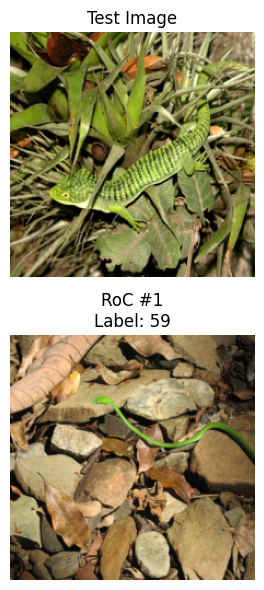

In [102]:
index = 88

print(f"True class: {test_datasets['test2'][index][1]}")  

pred = des.predict_weighted_robust_multi(test_datasets['test2'][index][0], kA=15, kB=15, explain=True, mode='intersection')

In [103]:
pred

0

True class: 5

=== Explainability Report (Multi-Embed RoC) ===
RoC indices (multi-embed mode="fused"): [180 209 181 177 185 187 196]
Local labels in RoC: [6 6 6 5 6 6 6]

Model-level details:
 Model #0: VisionTransformer | comp=0.857 sim=0.487 w=0.162 -> pred=5 conf=0.846
 Model #1: VGG | comp=0.714 sim=0.738 w=0.838 -> pred=5 conf=0.979

🧠 Final prediction: 6
🔝 Top-5 predictions:
  - Class 6: 0.8157
  - Class 5: 0.1595
  - Class 115: 0.0003
  - Class 110: 0.0002
  - Class 113: 0.0002

Model weight distribution:
  Model #0: 0.1621
  Model #1: 0.8379

RoC visualization:


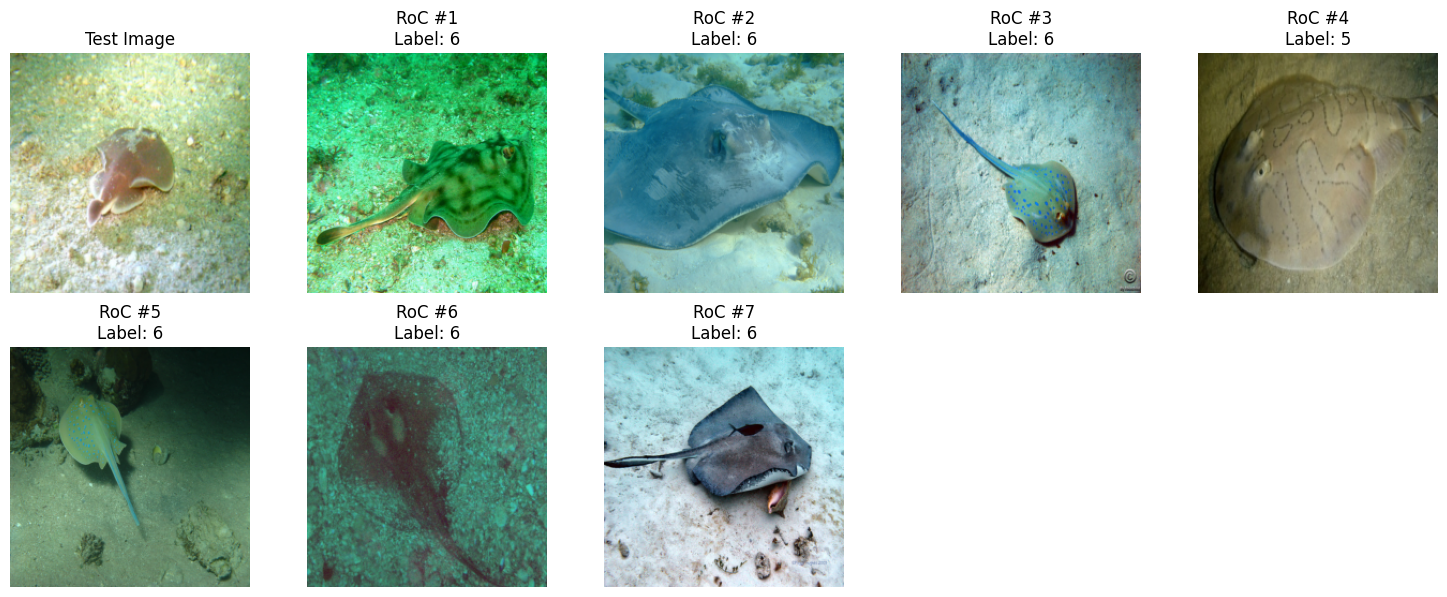

In [116]:
index = 10

print(f"True class: {test_datasets['test2'][index][1]}")  

pred = des.predict_weighted_robust_multi(test_datasets['test2'][index][0], kA=7, kB=7, explain=True, threshold=0, mode='fused')

In [117]:
pred

6

In [86]:
imagenet_classes[963]

'pizza'

In [106]:
import torch
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def evaluate_des_model(des_model, dataset, batch_size=1):
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    all_preds = []
    all_labels = []

    for imgs, labels in tqdm(loader):
        imgs = imgs.to(next(des_model.pool[0].parameters()).device)  # Match model device
        preds = []

        for img in imgs:
            pred = des_model.predict_weighted_robust_multi(
                img, kA=10, kB=10, explain=False, mode='fused'
            )
            preds.append(pred)

        all_preds.extend(preds)
        all_labels.extend(labels.cpu().numpy())

    acc = accuracy_score(all_labels, all_preds)
    print(f"Accuracy: {acc:.4f}")

    return acc


In [107]:
accuracy = evaluate_des_model(des, test_datasets['test1'])


100%|███████████████████████████████████████████████████████████████| 2000/2000 [11:10<00:00,  2.98it/s]

Accuracy: 0.6525
